# Testing Adaptation of Model

### Import Modules

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('default', category=DeprecationWarning, module='.*/qinfer/.*')
from __future__ import division # Ensures that a/b is always a float.

In [2]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import qinfer as qi
import models as m

reload(m)

<module 'models' from 'models.pyc'>

### Setup

Plotting and exporting. Change the `overwrite` flag if you want regenerated figures to be saved to disk.

In [3]:
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

SIZE = 14
plt.rc('font', size=SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)     # fontsize of the x any y labels
plt.rc('xtick', labelsize=10)      # fontsize of the tick labels
plt.rc('ytick', labelsize=10)      # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE)    # legend fontsize
plt.rc('figure', titlesize=SIZE)   # size of the figure title

overwrite = True
def export_figure(fig, name, extensions=['.png', '.pdf']):
    for ext in extensions:
        fname = '../fig/' + name + ext
        if not os.path.isfile(fname):
            print('Saving {}'.format(fname))
            fig.savefig(fname)
        elif overwrite:
            print('Overwriting {}'.format(fname))
            fig.savefig(fname)
        else:
            print('Skipping {}'.format(fname))

### Initialize QInfer Objects

In [4]:
ham_model = m.RabiRamseyModel()
ham_model._Q = np.array([1,1,0,0,0])

Model parameters:
   - 0: :math:`\Omega`, Rabi strength (MHz); coefficient of Sx
   - 1: :math:`\omega_e`, Zeeman frequency (MHz); coefficient of Sz
   - 2: :math:`\Delta \omega_c`, ZFS detuning (MHz); coefficient of Sz^2
   - 3: :math:`\A_N`, Nitrogen hyperfine splitting (MHz); modeled as incoherent average  
   - 4: :math:`T_2^-1`, inverse of electron T2* (MHz)

Experiment parameters:
 - mode: Specifies whether a reference or signal count is being performed.
 - t:   Pulse width
 - tau: Ramsey wait time (only relevent if mode is `RabiRamseyModel.RAMSEY`)
 - phi: Ramsey phase between pulses (")

In [5]:
true_value = np.array([5.555, 1.432, 0.579, 2.171, 0.035])
wide_prior = qi.UniformDistribution(np.array([
            [0,10],
            [0,10],
            [-5,5],
            [1.5,3.5],
            [100**-1,1**-1]
        ]))
narrow_prior = qi.UniformDistribution(
    true_value[:,np.newaxis] + 
    np.array([0.01,0.005,0.01,0.005,0.01])
        [:,np.newaxis]*([-1,1]*np.ones((5,2)))
)

In [10]:
def rabi_sweep(min_t=None, max_t=0.3, n=50):
    if min_t is None:
        min_t = max_t / n
    
    rabi_eps = np.array([
        np.linspace(min_t, max_t, n),
        np.zeros(n),
        np.zeros(n),
        np.ones(n) * ham_model.RABI
    ]).T
    rabi_eps = np.array(list(zip(*rabi_eps.T)), dtype=ham_model.expparams_dtype)
    return rabi_eps

def ramsey_sweep(min_tau=None, max_tau=2, tp=0.01, phi=0, n=50):
    if min_tau is None:
        min_tau = max_tau / n
    
    ramsey_eps = np.array([
        tp * np.ones(n),
        np.linspace(min_tau, max_tau, n),
        phi * np.ones(n),
        np.ones(n) * ham_model.RAMSEY
    ]).T
    ramsey_eps = np.array(list(zip(*ramsey_eps.T)), dtype=ham_model.expparams_dtype)
    return ramsey_eps

### Speed Tests

In [11]:
%timeit -n1 -r1 ham_model.likelihood(1, wide_prior.sample(1000), rabi_sweep(max_t=0.3,n=50))
%timeit -n1 -r1 ham_model.likelihood(1, wide_prior.sample(1000), ramsey_sweep(max_tau=2,n=50))

1 loop, best of 1: 475 ms per loop
1 loop, best of 1: 853 ms per loop


In [26]:
updater = qi.SMCUpdater(ham_model, 5000, narrow_prior)
rabi_eps = rabi_sweep(max_t=0.3,n=50)
ramsey_eps = ramsey_sweep(max_tau=2,n=50)
%timeit -n1 -r1 updater.bayes_risk(rabi_eps)
%timeit -n1 -r1 updater.bayes_risk(ramsey_eps)

1 loop, best of 1: 2.2 s per loop
1 loop, best of 1: 4.09 s per loop


###  Test Risk

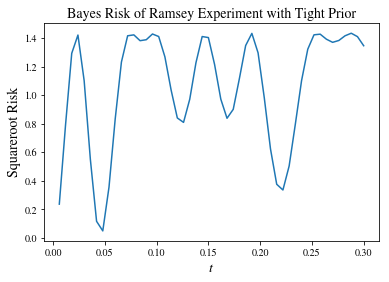

In [24]:
updater = qi.SMCUpdater(ham_model, 5000, narrow_prior)
rabi_eps = rabi_sweep(max_t=0.3,n=50)
plt.plot(rabi_eps['t'], np.sqrt(updater.bayes_risk(rabi_eps)))
plt.title('Bayes Risk of Rabi Experiment with Tight Prior')
plt.xlabel(r'$t~(\mu s)$')
plt.ylabel(r'Squareroot Risk')

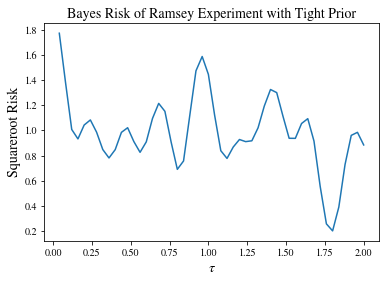

In [25]:
updater = qi.SMCUpdater(ham_model, 5000, narrow_prior)
ramsey_eps = ramsey_sweep(max_tau=2,n=50)
plt.plot(ramsey_eps['tau'], updater.bayes_risk(ramsey_eps))
plt.title('Bayes Risk of Ramsey Experiment with Tight Prior')
plt.xlabel(r'$\tau~(\mu s)$')
plt.ylabel(r'Squareroot Risk')

### Adaptive Simulations

In [ ]:
updater = qi.SMCUpdater(ham_model_cached, 1000, model_prior)

for idx_eps in range(100):
    pass